# lepton energy scale morphing

To account for the energy scale systematic uncertainty, the individual lepton energy is varied up and down to generate morphing templates.  This is susceptible to statistical fluctuations in the number of events have leptons with energy near bin boundaries.  To remove this issue, a method where the morphing is done based on the bin content is tested here.  

In [12]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

import scripts.fit_helpers as fh
import scripts.plot_tools as pt

np.set_printoptions(precision=3)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':18,
             'ytick.labelsize':18,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
import matplotlib
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 36381,
  "iopub_port": 43845,
  "stdin_port": 48945,
  "control_port": 59637,
  "hb_port": 36783,
  "ip": "127.0.0.1",
  "key": "13d851bf-0a8326ba1eeb6c5482df9394",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-15020270-0809-4fb9-a1eb-a9994f6f1e8d.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [37]:
# initialize fit data
infile = open('local_data/fit_data_asimov.pkl', 'rb')
fit_data = pickle.load(infile)
sdata = fit_data.get_selection_data('mumu')['cat_gt2_eq1_b']
infile.close()

# get parameter data
parameters = fit_data._parameters
pinit = parameters['val_init'].values

# get raw data
cut = pt.categories['cat_gt2_eq1_b'].cut
jet_cut = pt.categories['cat_gt2_eq1_b'].jet_cut
dm = pt.DataManager(input_dir     = 'local_data/flatuples/updated_e_sf/mumu_2016',
                    dataset_names = pt.dataset_dict['muon'],
                    selection     = 'mumu',
                    scale         = 35.9e3,
                    cuts          = ' and '.join([pt.cuts['mumu'], cut, jet_cut]),
                    features      = ['trailing_lepton_pt']
                   )                                   
df_data = dm.get_dataframe('data')

Loading dataframes: 100%|███████████████| 7.00/7.00 [00:01<00:00, 5.59it/s]


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


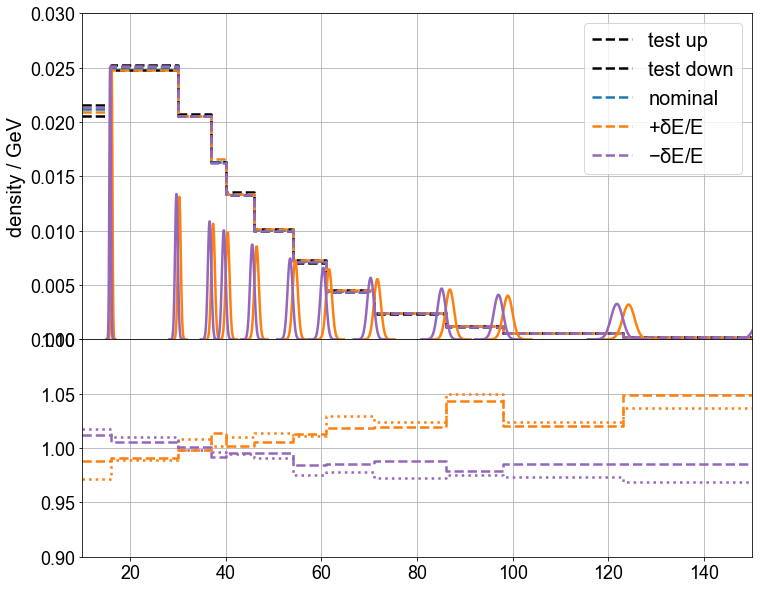

In [46]:
# get the data to be morphed
bins = sdata['bins']
x = bins[:-1]
dx = bins[1:] - bins[:-1]
y = sdata['templates']['data']['val']
yvar = sdata['templates']['data']['var']

# generate resolution kernels
sigma = 0.01
xup, xdown = x/(1-sigma), x/(1+sigma)
xx, yy = [], []
for xpt in np.concatenate([xdown, xup]):
    pt_scan = np.linspace((1 - 5*sigma)*xpt, (1 + 5*sigma)*xpt, 50)
    xx.append(pt_scan)
    yy.append(norm.pdf(pt_scan, xpt, 0.01*xpt)/100)
xx_down, yy_down = np.array(xx[:x.size]), np.array(yy[:x.size])
xx_up, yy_up = np.array(xx[x.size:]), np.array(yy[x.size:])

yavg = y.copy()
#yavg[:-1] = y[:-1] + (y[:-1] + y[1:])/2

dy_up, dy_down = np.zeros(y.size), np.zeros(y.size)
dy_up[1:] += yavg[:-1]*abs(xdown[1:] - x[1:])/dx[:-1] 
dy_up[:-1] -= yavg[:-1]*abs(xdown[1:] - x[1:])/dx[:-1]
dy_down[:-1] += yavg[1:]*abs(xup[1:] - x[1:])/dx[1:] 
dy_down -= yavg*abs(xup - x)/dx
dy_up[0] = -dy_down[0]
y_up, y_down = y + dy_up/np.sqrt(2), y + dy_down/np.sqrt(2)

# using default approach
#y_up_nom, _ = np.histogram()

# produce the plot
fig, axes = plt.subplots(2, 1, figsize=(12, 10), facecolor='white', sharex=True, gridspec_kw={'height_ratios': [3, 2]})
fig.subplots_adjust(hspace=0)

ax = axes[0]
lepton_pt = df_data.trailing_lepton_pt.values
y_test_up, _ = np.histogram(lepton_pt*(1 + sigma), bins)
ax.plot(x, y_test_up/(dx*y_test_up.sum()), 'k--', drawstyle='steps-post', label='test up')
y_test_down, _ = np.histogram(lepton_pt*(1 - sigma), bins)
ax.plot(x, y_test_down/(dx*y_test_down.sum()), 'k--', drawstyle='steps-post', label='test down')

ax.plot(x, y/(y.sum()*dx), 'C0--', drawstyle='steps-post', label='nominal')
ax.plot(x, y_up/(y_up.sum()*dx), 'C1--', drawstyle='steps-post', label=r'$+\delta E/E$')
ax.plot(x, y_down/(y_down.sum()*dx), 'C4--', drawstyle='steps-post', label=r'$-\delta E/E$')
ax.plot(xx_up[1:].T, yy_up[1:].T, 'C1-')
ax.plot(xx_down[1:].T, yy_down[1:].T, 'C4-')
#ax.set_xlim(x[0], x[-1])
ax.set_xlim(x[0], 150)
ax.set_ylim(0, 0.03)
ax.set_xlabel(r'$p_{T}^{\mu}$ [GeV]')
ax.set_ylabel('density / GeV')
ax.grid()

ax.legend()

ax = axes[1]
ax.plot(x, (y_test_up/y)*(y.sum()/y_test_up.sum()), 'C1:', drawstyle='steps-post')
ax.plot(x, (y_test_down/y)*(y.sum()/y_test_down.sum()), 'C4:', drawstyle='steps-post')
ax.plot(x, (y_up/y)*(y.sum()/y_up.sum()), 'C1--', drawstyle='steps-post')
ax.plot(x, (y_down/y)*(y.sum()/y_down.sum()), 'C4--', drawstyle='steps-post')
ax.set_ylim(0.9, 1.1)
ax.grid()

plt.savefig('plots/systematics/energy_histo_morphing.pdf')
plt.show()